In [1]:
import sys, os
path = os.path.dirname(os.path.abspath(os.curdir))
if path not in sys.path:
    sys.path.insert(0, path)

import tqdm
import numpy as np
import scipy as sp
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import src.SimData as sim_data
import src.Simulator as sim_system
import src.Optimizer as opt
import src.Model_free_methods as free_based

from pathos.multiprocessing import ProcessPool
from joblib import Parallel, delayed



In [2]:

###* Input files and function

reactions_file = "../reactions/reactionsCompleteV2.json"

const_dict = {
        "F0": 1.5e15,           # cm^-2
        "S0": 3e13,             # cm^-2
        
        "R": 0.00831442,        # kJ/mol*K
        "kBoltz": 1.380649e-23, # J/K
}

initial_state_dict = {
                    'O_F': 0.05, 'O2_F':0.05, 'CO_F':0.05, 'CO2_F':0.01, 
                    'O_S': 0.5, 'CO_S':0.1, 'Vdb_S':0.05, 'Odb_S': 0.05,
                    'COdb_S': 0.0
                    }


###* Functions for the data transformation
def compute_flux(const_dict, exp_dict, specie, molar_mass):
    den = exp_dict.get(specie, 0.0)
    v_th = np.sqrt((8.0 * const_dict['R'] * 1000 * exp_dict['Tnw'])/(molar_mass * np.pi))
    flux = 0.25 * v_th * den * 100
    return flux


def compute_remaining_flux(const_dict, exp_dict, molar_mass): 
    den = exp_dict['N'] - exp_dict['O'] - exp_dict['CO']
    v_th = np.sqrt((8.0 * const_dict['R'] * 1000 * exp_dict['Tnw'])/(molar_mass * np.pi))
    flux = 0.25 * v_th * den * 100
    return flux


####? EavgMB data extracted from the Booth et al. 2019 paper
p_data_exp = [0.2, 0.3, 0.4, 0.5, 0.6, 0.75, 1.5]
EavgMB_data = [1.04, 0.91, 0.87, 0.83, 0.77, 0.5, 0.001]
interpolator = sp.interpolate.interp1d(p_data_exp, EavgMB_data, kind='linear', fill_value=0.001, bounds_error=False)

transformations_exp = {
    'Tw':       lambda const_dict, exp_dict: exp_dict['Tw'] + 273.15,
    'fluxO' :   lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O', 0.016),
    'fluxO2' :  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O2', 0.032),
    'fluxO3' :  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O3', 0.048),
    'fluxC':    lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'C', 0.012),
    'fluxCO':   lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'CO', 0.028),
    'fluxCO2':  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'CO2', 0.048),
    'EavgMB':   lambda const_dict, exp_dict: interpolator(exp_dict['pressure']).item(),
    'Ion':      lambda const_dict, exp_dict: 1e14 * exp_dict["current"]
}


output_folder_path = "../Buffer_Data"
exp_data_file = "Experimental_data_CO_Jorge.hdf5"

####! bounds observables
lower_bounds = np.array([1e-8, 1e-8, 0.0, \
                    1e-5, 1e-5, 1e-5, 1e-5, 1e-5, \
                    1e-5, 1e-5, 1e-5, 1e-5, 1e-5
                    ])

upper_bounds = np.array([5e-1, 1e-2, 30.0, \
                    1.0, 1.0, 1.0, 1.0, 1.0, \
                    1.0, 1.0, 1.0, 1.0, 1.0
                    ])


##! define the default parameters
params_default_init = [
                0.01634, 1.67e-4, 19.75, \
                1.0, 1.0, 1e-2, 1e-1, 1e-1, \
                1e-2, 1e-1, 1e-1, 1e-1, 1e-1
                ]

params_default_norm = []
for idx, param in enumerate(params_default_init):
    value = (param - lower_bounds[idx])/(upper_bounds[idx] - lower_bounds[idx])
    params_default_norm.append(value)


##! define the optimization function
def func_optimization(params_input, flag='numpy'):
    
    ##! normalize variables
    params = [0] * len(params_input)
    for idx, param in enumerate(params_input):
        params[idx] = lower_bounds[idx] + (upper_bounds[idx] - lower_bounds[idx]) * param
    
    A_d, B_d, E_d, SF_1, SF_2, SF_3, SF_4, SF_5, SF_6, SF_7, SF_8, SF_9, SF_10 = params
    
    if flag=='numpy':
        nu_d_mod = lambda T: 1e15 * (A_d + B_d * np.exp(E_d/(const_dict['R'] * T)))
    elif flag=='torch':
        nu_d_mod = lambda T: 1e15 * (A_d + B_d * torch.exp(E_d/(const_dict['R'] * T)))
    else:
        raise ValueError(f"{flag} does not exist")
    
    dict_mod_vec = [
    {"id": 2, "rate": None, "model_dict": {"nu_d": nu_d_mod}},
    {"id": 10, "rate": None, "model_dict": {"nu_d": nu_d_mod}},
    {"id": 31, "rate": None, "model_dict": {"SF": SF_2, "nu_d": nu_d_mod}},
    
    {"id": 30, "rate": None, "model_dict": {"SF": SF_1}},
    {"id": 32, "rate": None, "model_dict": {"SF": SF_3}},
    {"id": 33, "rate": None, "model_dict": {"SF": SF_4}},
    {"id": 34, "rate": None, "model_dict": {"SF": SF_5}},
    
    {"id": 35, "rate": None, "model_dict": {"SF": SF_6}},
    {"id": 36, "rate": None, "model_dict": {"SF": SF_7}},
    {"id": 37, "rate": None, "model_dict": {"SF": SF_8}},
    {"id": 38, "rate": None, "model_dict": {"SF": SF_9}},
    {"id": 39, "rate": None, "model_dict": {"SF": SF_10}},
    ]
    
    return dict_mod_vec


loss_function = lambda exp, teo: np.mean((np.reciprocal(exp)*(exp-teo))**2)

exp_file = os.path.join(output_folder_path, exp_data_file)
sim = sim_system.Simulator(reactions_file, const_dict, exp_file, initial_state_dict, transformations_exp=transformations_exp)

optimizer = opt.Optimizer(sim, func_optimization, loss_function)


  d[CO2_F]/dt = -CO2_F*r_29 + r_28*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[CO_F]/dt = -CO_F*O_F*r_35 - 0.02*CO_F*O_S*r_40 - 0.02*CO_F*Odb_S*r_61 - 0.02*CO_F*Vdb_S*r_60 - CO_F*r_31 - CO_F*r_33 - 0.02*CO_F*r_36*(-CO_S - COdb_S - O_S - Odb_S - Vdb_S + 1.0) + r_30*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[CO_S]/dt = CO_F*r_36*(-CO_S - COdb_S - O_S - Odb_S - Vdb_S + 1.0) - CO_S*O_F*r_39 - CO_S*r_37 - CO_S*r_43 - CO_S*r_44 - CO_S*r_45 - CO_S*r_46 + r_32*(-CO_S - COdb_S - O_S - Odb_S - Vdb_S + 1.0)
  d[COdb_S]/dt = CO_F*Vdb_S*r_60 - COdb_S*O_F*r_62 - COdb_S*r_54 - COdb_S*r_55 - COdb_S*r_56 - COdb_S*r_57 - COdb_S*r_59 + Vdb_S*r_49
  d[O2_F]/dt = -O2_F*O_F*r_15 - O2_F*r_10 - O2_F*r_12 - O2_F*r_14 + r_9*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[O_F]/dt = -CO_F*O_F*r_35 - 0.02*CO_S*O_F*r_39 - 0.02*COdb_S*O_F*r_62 - O2_F*O_F*r_15 - 2*O_F**2*r_8 - 0.02*O_F*O_S*r_7 - 0.02*O_F*Odb_S*r_27 - 0.02*O_F*Vdb_S*r_26 - O_F*r_11 - O_F*r_2 - O_F*r_34 - O_F*r_4 - 0.02*O_F*r_5*(-CO_S - COdb_S - O_S - Odb_S - Vdb_S + 1.

In [4]:


## 1, 2
x1_vec = params_default_norm[3] * np.linspace(-1.0, 0.0, 25) * 0.5 + params_default_norm[3]
x2_vec = params_default_norm[4] * np.linspace(-1.0, 0.0, 25) * 0.5 + params_default_norm[4]

X1, X2 = np.meshgrid(x1_vec, x2_vec)

points_vec = np.vstack([X1.ravel(), X2.ravel()]).T  # shape=(10000, 2)
params_vec = []

for idx, vec in enumerate(points_vec):
    
    params_aux = params_default_norm.copy()
    
    params_aux[3] = vec[0]
    params_aux[4] = vec[1]
    
    params_vec.append(params_aux)


In [6]:


def batched_objective(params_list):
    return [optimizer.objective_function(p) for p in params_list]

batch_size = 8
batches = [
    params_vec[i : i+batch_size]
    for i in range(0, len(params_vec), batch_size)
]

results = []
for batch in tqdm.tqdm(batches, desc="Optimizing batches"):
    results.extend(Parallel(n_jobs=-1, backend="loky")(
        delayed(optimizer.objective_function)(p) for p in batch
    ))




Optimizing batches:   0%|          | 0/79 [00:00<?, ?it/s]

Optimizing batches: 100%|██████████| 79/79 [03:29<00:00,  2.65s/it]


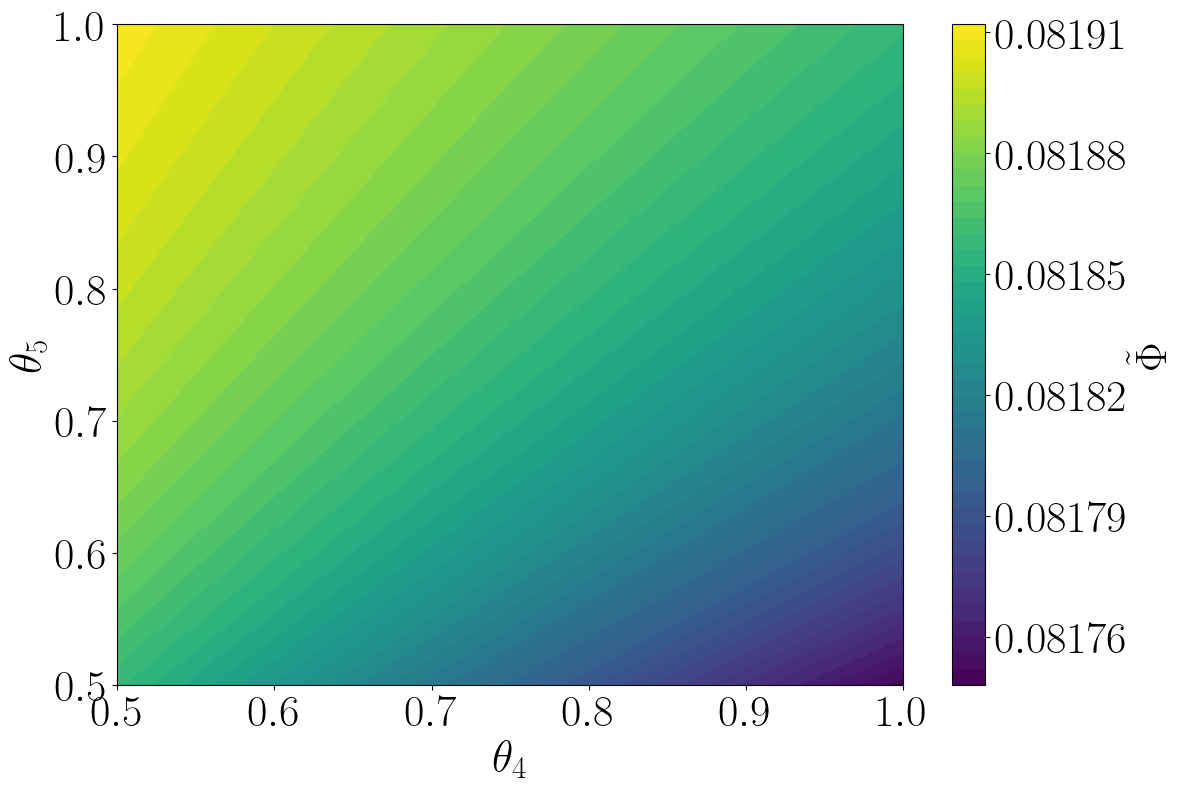

In [8]:

from matplotlib.ticker import MaxNLocator, LogLocator, FormatStrFormatter

fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

Z = np.array(results).reshape(X1.shape[0], X2.shape[0])

# filled contour with a logarithmic color scale
cont = plt.contourf(
    X1, X2, Z,
    levels=40)    # colorbar on log scale

cbar = fig.colorbar(
    cont,
    ax=ax,
)

cbar.locator = MaxNLocator(nbins=6)
cbar.update_ticks()

# cbar = plt.colorbar(cont)
cbar.set_label(r'$\tilde{\Phi}$', fontsize=32)
cbar.ax.tick_params(labelsize=32)


ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
plt.xlabel(r'$\theta_4$', fontsize=32)
plt.ylabel(r'$\theta_5$', fontsize=32)

plt.tight_layout()
plt.savefig("loss_surface_25_poorly_correlated.png")